# Credit Card Fraud Detection
#### By Shadi Bavar, Matthew Euliano, and Claire Parisi


##### Importing Required Libraries & Dataset

In [1]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC

In [2]:
# Import Data
data = pd.read_csv('creditcard.csv')

# Get samples for each class
fraudsDF = data[data.Class == 1]
normalDF = data[data.Class == 0]
N = len(data)

#### Regularize Features & Data Prep

In [3]:
#Scaling amount 
std_scale = StandardScaler()
data['Amount'] = std_scale.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = std_scale.fit_transform(data['Time'].values.reshape(-1, 1))
# data = data.drop(['Time'], axis=1)

#Split dataset into inputs (x) and labels (y)
x = data.drop(['Class'], axis = 1)
y = data['Class']

#### Break dataset into Training and Testing Sets Representative of the Imbalanced Dataset

In [25]:
#split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

#check distributions of data
fraud_train_pct = y_train[y_train== 1].value_counts()/len(y_train)*100
fraud_test_pct = y_test[y_test == 1].value_counts()/len(y_test)*100

print('Training set frauds:', round(fraud_train_pct[1], 2), '%')
print('Test set frauds:', round(fraud_test_pct[1], 2), '%')


Training set frauds: 0.17 %
Test set frauds: 0.17 %


# Autoencoders

In [5]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils

In [6]:
class Autoencoder(nn.Module):
    '''
    We are building an autoencoder with 4 connected layers with 14, 7, 7, 29 Neurons
    First two layers act as encoder
    Last two layers act as decoder
    last layer of 29 neurons corresponds to number of features
    '''
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(30, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )
        
        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 30),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Convert DF to ND-Array
x_train1 = x_train.values

# Use only Non-Fraudulent Class for training
X_train = x_train1[y_train == 0]

In [9]:
model = Autoencoder().double().cpu()

In [10]:
# Setup Neural Network Training 
num_epochs = 25
minibatch_size = 32
learning_rate = 1e-3

train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=10e-05)

history = {}
history['train_loss'] = []
history['test_loss'] = []

In [11]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)
    

torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/25], loss:0.8153
epoch [2/25], loss:0.7600
epoch [3/25], loss:0.7467
epoch [4/25], loss:0.7417
epoch [5/25], loss:0.7305
epoch [6/25], loss:0.7163
epoch [7/25], loss:0.7122
epoch [8/25], loss:0.7102
epoch [9/25], loss:0.7090
epoch [10/25], loss:0.7082
epoch [11/25], loss:0.7078
epoch [12/25], loss:0.7070
epoch [13/25], loss:0.7066
epoch [14/25], loss:0.7061
epoch [15/25], loss:0.7059
epoch [16/25], loss:0.7057
epoch [17/25], loss:0.7056
epoch [18/25], loss:0.7051
epoch [19/25], loss:0.7051
epoch [20/25], loss:0.7048
epoch [21/25], loss:0.7049
epoch [22/25], loss:0.7046
epoch [23/25], loss:0.7044
epoch [24/25], loss:0.7042
epoch [25/25], loss:0.7040


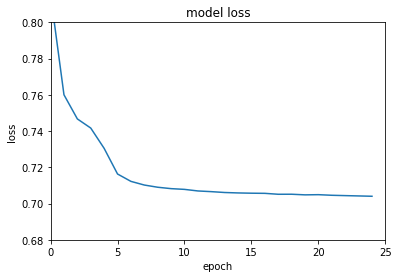

In [27]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,25,0.68,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [28]:
x_test = x_test.values
test_loader = data_utils.DataLoader(x_test, batch_size=1, shuffle=False)


pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [29]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,11398.000000
mean,0.760256,0.002544
std,7.585008,0.050379
min,0.039087,0.000000
25%,0.254690,0.000000
50%,0.399558,0.000000
75%,0.630053,0.000000
max,1655.990000,1.000000


In [31]:
# This saves/loads nn models

model = Autoencoder().double().cpu()
model.load_state_dict(torch.load('./credit_card_model.pth'))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=14, bias=True)
    (1): Tanh()
    (2): Linear(in_features=14, out_features=7, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=7, bias=True)
    (1): Tanh()
    (2): Linear(in_features=7, out_features=30, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
  )
)

In [33]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [32]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').